<a href="https://colab.research.google.com/github/Klavierkonzert/CV/blob/Digits-classification/Handwritten_digits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание рукописных цифр
Данный блокнот можно найти по ссылке: https://colab.research.google.com/drive/1zIdXu3urd8_FcJ7pi9CTILsHCfahdOXr?usp=sharing (Некоторые графики не отображаются корректно в листинге. В среде Google Colab можно перезапустить этот код)


Автор - Александр Кладнев.


## Константы и библиотеки

In [ ]:
IM_DIM = 28*28
IM_HEIGHT=28
N_IM_CHANNELS = 1
N_CLASSES = 10
N_MAX_EPOCHS = 20
BATCH_SIZE = 64
LR=3e-4
N_REPEAT = 10

In [ ]:
import math

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

import sklearn.metrics

In [ ]:
from IPython.display import clear_output
import pandas as pd

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

Следующая библиотека нужна для некоторых матричных операций

In [ ]:
!pip install einops
import einops

##MNIST
В этом блоке загружжается набор данных MNIST

In [ ]:
MNIST_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform=MNIST_transform)
train_DL = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=MNIST_transform)
val_DL = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
dataiter = iter(train_DL) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9)

print('Train and test batch have the following shapes: ')
print(images.shape)
print(labels.shape)

Train and test batch have the following shapes: 
torch.Size([64, 1, 28, 28])
torch.Size([64])


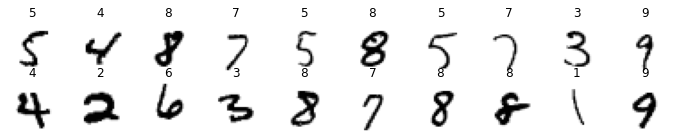

In [ ]:
figure = plt.figure(figsize=(12, 2))
num_of_images = 60//3
for i in range(1, num_of_images + 1):
    plt.subplot(2, 10, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.title(str(labels[i].item()))

## Функции: обучение, оценка

### Обучение

In [ ]:
def fit_epoch(model, train_dataloader, optimizer, criterion):
    running_loss, processed_data_size = 0.0, 0

    for X_batch, Y_batch in train_dataloader:
        X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)

        optimizer.zero_grad()
        logits = model(X_batch)#.float())# returns reconstruction and latent representation
        loss = criterion(logits, Y_batch)# the res is in DEVICE
        loss.backward()
        optimizer.step()

        running_loss +=loss.item() * X_batch.size(0)
        processed_data_size += X_batch.size(0)
    train_loss = running_loss/processed_data_size
    return train_loss

In [ ]:
def eval_epoch(model, val_dataloader, optimizer, criterion):
    running_loss, processed_data_size = 0.0, 0

    model.eval()

    with torch.no_grad():
      for X_batch, Y_batch in val_dataloader:
        logits = model(X_batch.to(DEVICE)).to('cpu')

        loss = criterion(logits, Y_batch)#.to('cpu') # the res is in CPU

        running_loss += loss.item() * X_batch.size(0)
        processed_data_size += X_batch.size(0)
    val_loss = running_loss/processed_data_size

    return val_loss

Строит кривые график функции потерь для тестовой и ваоиационной выборок

In [ ]:
def plot_loss(loss, val_loss, fig=None):
    if fig is None:
        plt.figure(figsize=(12, 6))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.xticks(np.arange(0, len(loss), step=1))
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    if fig is None:
        plt.show()

Функция, которая обучает модель в течение заданного числа эпох с заданными загрузчиками тестовых и валидационных выборок, с заданной функцией потерь (`crit`) и градиентным оптимизатором

In [ ]:
from tqdm import tqdm, tqdm_notebook

def train(model, train_dataloader, val_dataloader,  crit, optim, lr_scheduler=None, n_epochs=N_MAX_EPOCHS,
              bool_plot=True):
    l_history = []
    train_time = 0
    log_template = "\n Epoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"# train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    with tqdm(desc="epoch", total=n_epochs) as pbar_outer:
      for i_epoch in range(n_epochs):
          time0 = time()
          train_loss = fit_epoch(model, train_dataloader, optim, crit)
          train_time += time()-time0
          val_loss = eval_epoch(model, val_dataloader, optim, crit)

          l_history.append([train_loss, val_loss])

          if lr_scheduler is not None:
              lr_scheduler.step()


          #Visualisation
          clear_output(wait=True)
          print(f'Epoch {i_epoch}: Current loss is {train_loss}')
          pbar_outer.update(1)
          tqdm.write(log_template.format(ep=i_epoch+1, t_loss=train_loss, v_loss=val_loss))#, t_acc=train_acc, v_acc=val_acc))

          if bool_plot:
              np_h = np.array(l_history)
              plot_loss(np_h[:,0], np_h[:,1])
    return l_history, train_time

### Оценка модели

Считает среднее значение метрики качества (в качестве нее выбирается _accuracy_)

In [ ]:
def evaluate(model, val_dataloader, metrics):
    res = 0
    running_loss, processed_data_size = 0.0, 0
    with torch.no_grad():
      #logits = []
      for X_batch, Y_batch in val_dataloader:
          inputs = X_batch.to(DEVICE)
          model.eval()
          #outputs = model(inputs).cpu()
          #logits.append(outputs)
          Y_pred = torch.argmax((model(inputs).to('cpu')), 1)

          batch_res = metrics(Y_batch, Y_pred)
          res += batch_res * Y_pred.size(0)
          processed_data_size += Y_pred.size(0)
    res = res/processed_data_size
    #probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return res

In [ ]:
def get_total_params(model, p_type='all'):
    '''_type is either all or train'''
    if p_type == 'train':
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

Строит график зависимости между числом параметров и точностью предсказаний

In [ ]:
def plot_acc_params_dependency(l_n_parameters, l_acc, l_time=None, n_epochs=N_MAX_EPOCHS,
                               plot_new_fig=False, colour='b', ls='-', s_xscale='log', s_yscale=None):
    '''Plots accuracy-n_parameters dependency and annotates it with avg train time per epoch'''
    if plot_new_fig:
        plt.figure(figsize=(9, 5))
    plt.plot(l_n_parameters,  l_acc, c=colour, ls=ls)
    plt.xlabel("|params|")
    plt.ylabel("Accuracy")
    if s_xscale is not None:
        plt.xscale(s_xscale)
    if s_yscale is not None:
        plt.yscale(s_yscale)
    plt.scatter(l_n_parameters,  l_acc, c=colour)
    if l_time is not None:
        for i, t in enumerate(l_time):
            plt.annotate(np.round(t/n_epochs, 2), (l_n_parameters[i], l_acc[i]))

Строит график предсказаний зависимости трех щначений функции потерь от числа параметров

In [ ]:
def plot_loss_params_dependency(l_n_parameters, l_min_val_losses, l_min_train_losses, l_last_val_losses=None,
                                plot_new_fig=False, train_color = 'c', val_color = 'orange', s_xscale=None):
    """Plots min, last val loss value and min train values respectively to params number"""
    if plot_new_fig:
        plt.figure(figsize=(9, 5))
    plt.plot(l_n_parameters,  l_min_train_losses,  c = train_color)
    plt.plot(l_n_parameters,  l_min_val_losses,  c = val_color)
    if l_last_val_losses is not None:
        plt.plot(l_n_parameters,  l_last_val_losses, c = val_color, ls='--')
    plt.xlabel("|params|")
    plt.ylabel("Loss")
    if s_xscale is not None:
        plt.xscale(s_xscale)

    #plt.scatter(l_n_parameters,  l_acc, c=colour)
    #for i, t in enumerate(l_time):
    #    plt.annotate(np.round(t/n_epochs, 2), (l_n_parameters[i], l_acc[i]))

#### Visualisation of predictins

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание для одного сэпмла картинок"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Печать картинок и предсказаний к ним (с укаанием точности).

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

def plot_predicted_labeled_imgs(model, X_batch, Y_batch):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        rand_idx = int(np.random.uniform(0,BATCH_SIZE))
        X, Y = X_batch[rand_idx], Y_batch[rand_idx]

        fig_x.imshow((1-X).data.cpu().numpy().squeeze() , cmap='gray')
        fig_x.set_title(str(Y.item()))
        fig_x.grid(False)

        prob_pred = predict_one_sample(model, X.unsqueeze(0))
        predicted_proba =np.max(prob_pred) *100
        y_pred = np.argmax(prob_pred)

        predicted_label = y_pred
        predicted_text = "{} : {:.2f}%".format(y_pred,predicted_proba)
        fig_x.text(1, 1, predicted_text ,
                   horizontalalignment='left',
                        verticalalignment='top',fontsize=10, color='red',fontweight='bold')

#### Typical workflow

In [ ]:
def typical_workflow(model, train_DL, val_DL,
                     n_epochs=N_MAX_EPOCHS, init_lr=LR, lr_params={'step_size': 9, 'gamma': 0.1}):
    '''Returns valuable estimates '''
    crit = nn.CrossEntropyLoss()# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
    opt = torch.optim.AdamW(lr=init_lr, params = model.parameters())
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=lr_params['step_size'], gamma= lr_params['gamma'])
    metrics = sklearn.metrics.accuracy_score
    h, t = train(model, train_DL, val_DL, crit=crit, optim=opt, n_epochs=n_epochs, lr_scheduler=lr_sched)

    e = evaluate(model, val_DL, metrics)
    n_params = get_total_params(model)
    return h, t, e, n_params

## Модели

### Перцептрон

#### Реализация

In [ ]:
class Perceptron(nn.Module):
#foreach picture in a batch Perceptron returns a 10-vector of probabilities
    def __init__(self, n_hidden_neurons=IM_DIM):
        super().__init__()

        self.A = torch.round(2*torch.rand(n_hidden_neurons,IM_DIM, requires_grad=False) -1).to(DEVICE)
        self.flatten = nn.Flatten()
        self.R = nn.Linear(n_hidden_neurons,N_CLASSES)
        # so that Perceptron model has 2 tens params: R and bias

    def forward(self, x):
        x = self.flatten(x)
        Ax = torch.matmul(self.A, x.T).T
        R = self.R(Ax)
        logits = R
        return logits

In [ ]:
p = Perceptron(n_hidden_neurons=IM_DIM//8).to(DEVICE)
crit = nn.CrossEntropyLoss()# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
opt = torch.optim.AdamW(lr=LR, params = p.parameters())
metrics = sklearn.metrics.accuracy_score
h, t = train(p, train_DL, val_DL, crit=crit, optim=opt)

In [ ]:
print('accuracy is '+str(evaluate(p, val_DL, metrics)))
print('percepton has '+str(get_total_params(p, 'train'))+  'parameters')

accuracy is 0.8938
990


#### Протестируем  различные варианты перцептрона
И подведем количество обучаемых параметров

In [ ]:
d_big_history = {}
#for i in range(0, 3):
i=0
n_iters=0
d_hist = {}

In [ ]:
i=0
lr = LR
for deg in range(3, 12):
    lr /= 2.0
    n_hidden_neurons = 4**deg
    p = Perceptron(n_hidden_neurons=n_hidden_neurons).to(DEVICE)
    crit = nn.CrossEntropyLoss()# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
    opt = torch.optim.AdamW(lr=lr, params = p.parameters())
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=9, gamma= 0.1)
    metrics = sklearn.metrics.accuracy_score
    h, t = train(p, train_DL, val_DL, crit=crit, optim=opt, n_epochs=3*N_MAX_EPOCHS, lr_scheduler=lr_sched)

    e = evaluate(p, val_DL, metrics)
    n_params = get_total_params(p)
    d_hist[n_hidden_neurons] = [h, t, e, n_params]

d_big_history[i] = [d_hist,get_total_params(p, 'train')]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(d_hist)

In [ ]:
df# Dataframe formed from training history

In [ ]:
df.to_excel('\content\drive\perceptron.xlsx')

In [ ]:
df2 = pd.read_excel('\content\drive\perceptron.xlsx')

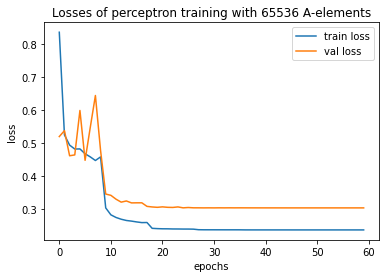

In [ ]:
!pip install asteval
from asteval import Interpreter
aeval = Interpreter()
l = aeval(df2[65536][0])

plt.plot(l)
plt.title('Losses of perceptron training with 65536 A-elements')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train loss', 'val loss'], loc='best')

[650, 2570, 10250, 40970, 163850, 655370]

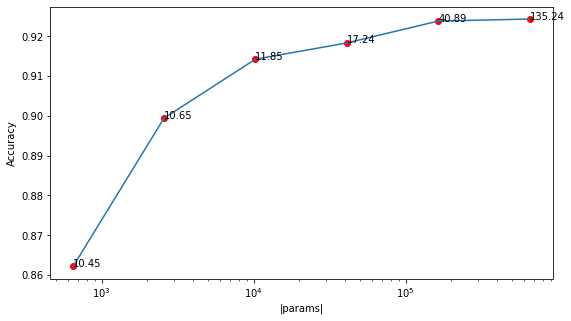

In [ ]:
n_parameters = [((4**d)*N_CLASSES+N_CLASSES) for d in range(3, 9)]
l_acc = list(df.iloc[2])
l_time = list(df.iloc[1])

plt.figure(figsize=(9, 5))
plt.plot(n_parameters,  l_acc)

plt.xlabel("|params|")
plt.ylabel("Accuracy")

plt.xscale("log")


plt.scatter(n_parameters,  l_acc, c='r')
for i, t in enumerate(l_time):
    plt.annotate(np.round(t/60, 2), (n_parameters[i], l_acc[i]))# 60 for 60 epochs
n_parameters

In [ ]:
get_total_params(p) # n params of perceptron with 4**9 A-elements

2621450

### Полносвязные сети (FC NNs)


####  FC with 2 layers

In [ ]:
class FC2(nn.Module):
#foreach picture in a batch Perceptron returns a 10-vector of probabilities
    def __init__(self, n_hidden_neurons=128):
        super().__init__()
        self.flatten = nn.Flatten()
        self.FC1= nn.Linear(IM_DIM, n_hidden_neurons)
        self.relu1 = nn.ReLU()
        self.FC2 = nn.Linear(n_hidden_neurons, N_CLASSES)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.FC1(x))

        # = x.view(x.size(0), -1)
        #x = self.fc(x)
        logits = self.FC2(x)
        return logits

In [ ]:
d_big_history = {}
d_hist = {}

In [ ]:

i=2
lr = LR
for deg in range(3,7):
    lr /= 2
    n_hidden_neurons = 4**deg
    fc2 = FC2(n_hidden_neurons=n_hidden_neurons).to(DEVICE)
    crit = nn.CrossEntropyLoss()# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
    opt = torch.optim.AdamW(lr=lr, params = fc2.parameters())
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=9, gamma= 0.1)
    metrics = sklearn.metrics.accuracy_score
    h, t = train(fc2, train_DL, val_DL, crit=crit, optim=opt, n_epochs=N_MAX_EPOCHS, lr_scheduler=lr_sched)

    e = evaluate(fc2, val_DL, metrics)
    n_params = get_total_params(fc2)
    d_hist[n_hidden_neurons] = [h, t, e, n_params]

d_big_history[i] = d_hist

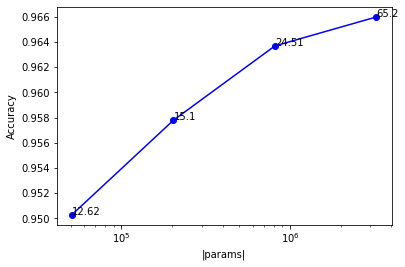

In [ ]:
df_fc2 = pd.DataFrame(d_big_history[2])
plot_acc_params_dependency(l_acc=list(df_fc2.iloc[2]), l_time=list(df_fc2.iloc[1]), l_n_parameters=list(df_fc2.iloc[3]))

#### FC with several layers

In [ ]:
class FC(nn.Module):
#foreach picture in a batch Perceptron returns a 10-vector of probabilities
    def __init__(self, n_hidden_layers=1, l_hidden_layers_dims=[128]):
        """The First layer is initialised as NN.Linear(IM_DIM, l_hidden_layers_dims[0]);
            The Last layer is initialised as nn.Linear(l_hidden_layers_dims[-1], N_CLASSES)"""
        assert (type(n_hidden_layers)==int) and (n_hidden_layers>0)
        assert len(l_hidden_layers_dims)==n_hidden_layers
        l_layers_dims=[IM_DIM]
        l_layers_dims.extend(l_hidden_layers_dims)

        super().__init__()

        self.flatten = nn.Flatten()
        self.linears = nn.ModuleList([nn.Linear(l_layers_dims[i],l_layers_dims[i+1])
                                       for i in range(n_hidden_layers)])
        self.l_relu = nn.ModuleList([nn.ReLU() for i in range(n_hidden_layers)])
        self.linear_last = nn.Linear(l_layers_dims[-1], N_CLASSES)

    def forward(self, x):
        x = self.flatten(x)
        for linear_layer, relu in zip(self.linears, self.l_relu):
            x = linear_layer(x)
            x = relu(x)

        # = x.view(x.size(0), -1)

        logits = self.linear_last(x)
        return logits

In [ ]:
lr = LR
i = 7
dl_dims ={}
# Different FC-layers configs are listed in dl_dims
dl_dims[3] = [[128, 64], [196, 98], [256,128],[392,196], [512, 256]]
dl_dims[4] = [[256,128,64],[392, 196, 98], [512, 256, 128],[784,512, 256]]
dl_dims[5] = [[192,160,128,96],[256,192,128,64],[392,168,98,50],[640, 480, 320, 160]]
dl_dims[6] = [[320, 256, 196, 128, 64], [640, 512,384,256,128]]
dl_dims[7] = [[320, 280, 240, 190, 128, 64],  [640, 512,384,256,128, 64]]

for i in range(3,8):
  d_hist ={}
  for j in range(0, len(dl_dims[i])):
    n_hidden_layers = i-1
    fc = FC(n_hidden_layers=n_hidden_layers, l_hidden_layers_dims=dl_dims[i][j])
    crit = nn.CrossEntropyLoss()# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
    opt = torch.optim.AdamW(lr=lr, params = fc.parameters())
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=9, gamma= 0.1)
    metrics = sklearn.metrics.accuracy_score
    h, t = train(fc, train_DL, val_DL, crit=crit, optim=opt, n_epochs=N_MAX_EPOCHS, lr_scheduler=lr_sched)

    e = evaluate(fc, val_DL, metrics)
    n_params = get_total_params(fc)
    d_hist[j] = [h, t, e, n_params]
  d_big_history[i] = d_hist

In [ ]:
print(get_total_params(fc, 'train'))
evaluate(fc, val_DL, metrics=metrics)

1167946


0.9849

In [ ]:
d_df_fc = {}
for i in range (2, 8):
    df = pd.DataFrame(d_big_history[i])
    df.to_excel('/content/drive/MyDrive/Graduation_paper/hist_of_FC'+str(i)+'_training.xlsx')
    d_df_fc[i]=df

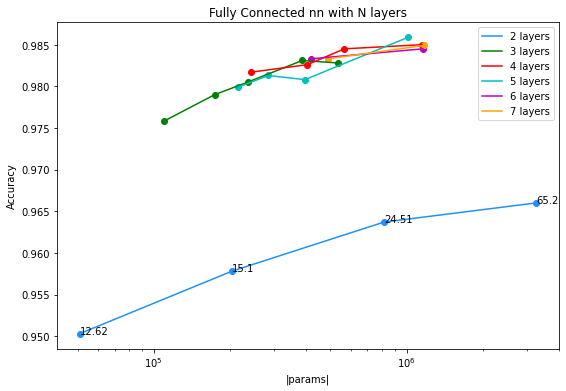

In [ ]:
colors = ['dodgerblue','g','r','c','m','orange']
plt.figure(figsize=(9,6))
plt.title('Fully Connected nn with N layers')
for i in range(2,8):
    #plt.figure(figsize=(9,6))
    plot_acc_params_dependency(l_acc=list(d_df_fc[i].iloc[2]), l_n_parameters=list(d_df_fc[i].iloc[3]),
                               l_time=( list(d_df_fc[i].iloc[1]) if i==2 else None),
                               colour=colors[i-2], s_xscale='log', s_yscale='linear')
plt.legend([(str(i)+' layers') for i in range(2,8)])

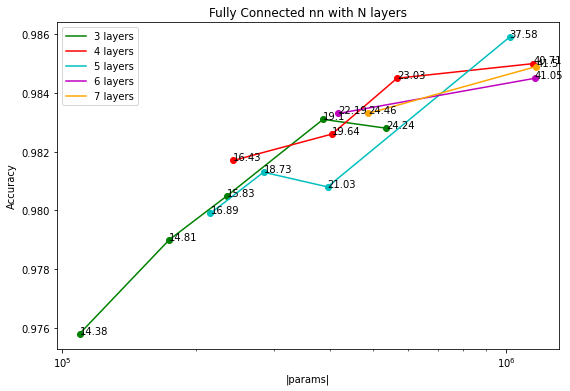

In [ ]:
plt.figure(figsize=(9,6))
plt.title('Fully Connected nn with N layers')
for i in range(3,8):
    #plt.figure(figsize=(9,6))
    plot_acc_params_dependency(l_acc=list(d_df_fc[i].iloc[2]), l_time=list(d_df_fc[i].iloc[1]), l_n_parameters=list(d_df_fc[i].iloc[3]),
                               colour=colors[i-2], s_xscale='log', s_yscale='linear')
plt.legend([(str(i)+' layers') for i in range(3,8)])

Text(0.5, 1.0, 'FC Loss-n_params dependency')

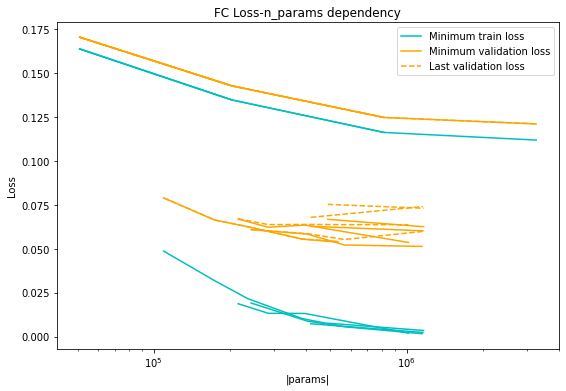

In [ ]:
#last_val_loss = d_big_history[i][j][0][-1][1]
plt.figure(figsize = (9,6))
i=2
l_n_parameters, l_min_val_losses, l_min_train_losses, l_last_val_losses = [],[],[],[]
for j in range(3,7):
    j = 4**j
    hh = np.array(d_big_history[i][j][0])
    l_n_parameters.append(d_big_history[i][j][3])
    l_min_train_losses.append(hh[:,0].min())
    l_min_val_losses.append(hh[:, 1].min())
    l_last_val_losses.append(hh[-1,1])
    plot_loss_params_dependency(l_n_parameters, l_min_val_losses, l_min_train_losses, l_last_val_losses, s_xscale='log')#, val_color='r', train_color='dodgerblue')
#plt.legend(['Minimum train loss', 'Minimum validation loss', 'Last validation loss' ], loc='upper right')
for i in range(3,8):
    l_n_parameters, l_min_val_losses, l_min_train_losses, l_last_val_losses = [],[],[],[]
    for j in range(0, len(dl_dims[i])):
        hh = np.array(d_big_history[i][j][0])
        l_n_parameters.append(d_big_history[i][j][3])
        l_min_train_losses.append(hh[:,0].min())
        l_min_val_losses.append(hh[:, 1].min())
        l_last_val_losses.append(hh[-1,1])
    plot_loss_params_dependency(l_n_parameters, l_min_val_losses, l_min_train_losses, l_last_val_losses, s_xscale='log')
plt.legend(['Minimum train loss', 'Minimum validation loss', 'Last validation loss' ])
plt.title("FC Loss-n_params dependency")

In [ ]:
len(d_big_history[2])

4

In [ ]:
d_big_history

### Сверточные сети

In [ ]:
def check_cnn_params_correctness(n_conv_layers, l_kernel_sizes, l_strides, l_paddings, l_poolings_sizes, im_dim=IM_DIM):
    ''''returns 1-dim size (i.e. height=width) of an image. If parameters are incorrest, returned size is less than 1'''
    assert (len(l_kernel_sizes)>=n_conv_layers) and (len(l_strides)>=n_conv_layers) and (len(l_paddings)>=n_conv_layers)
    im_size = round(math.sqrt(im_dim))
    for i in range(n_conv_layers):
        im_size = (im_size - l_kernel_sizes[i] +2*l_paddings[i])/l_strides[i] +1
        im_size = im_size// l_poolings_sizes[i]
    return im_size

In [ ]:
class CNN(nn.Module):
#foreach picture in a batch Perceptron returns a 10-vector of probabilities
    def __init__(self, n_conv_layers, n_FC_layers, l_n_conv_layers, l_kernel_sizes, l_strides, l_paddings, l_fc_neurons):
        """ """
        assert (type(n_conv_layers)==int) and (n_conv_layers>0)
        assert (len(l_n_conv_layers)>=n_conv_layers) and (len(l_kernel_sizes)>=n_conv_layers) and (len(l_strides)>=n_conv_layers) and (len(l_paddings)>=n_conv_layers)
        assert (type(n_FC_layers)==int) and (n_FC_layers>0)
        assert len(l_fc_neurons)==(n_FC_layers-1)

        super().__init__()

        l_n_conv_layers_ =[ N_IM_CHANNELS ]
        l_n_conv_layers_.extend(l_n_conv_layers)

        self.convs = nn.ModuleList([nn.Sequential(
                                                  nn.Conv2d(l_n_conv_layers_[i],l_n_conv_layers_[i+1],
                                                            kernel_size=l_kernel_sizes[i], stride=l_strides[i], padding=l_paddings[i]),
                                                  nn.ReLU(),
                                                  nn.MaxPool2d(kernel_size=2)
                                                  )
                                          for i in range(n_conv_layers)])
        print(f'CNN initialized with {len(self.convs)} conv-layers')


        self.flatten = nn.Flatten()


        im_size = round(math.sqrt(IM_DIM))
        n_in_neurons = round(check_cnn_params_correctness(n_conv_layers, l_kernel_sizes, l_strides, l_paddings,
                                                          l_poolings_sizes=[2 for j in range(n_conv_layers)], im_dim=IM_DIM))
        n_in_neurons = (n_in_neurons**2) * l_n_conv_layers_[-1]
        l_n_fc_layers=[ n_in_neurons]
        l_n_fc_layers.extend(l_fc_neurons)

        self.linears = nn.ModuleList([nn.Sequential(
                                                  nn.Linear(in_features=l_n_fc_layers[i], out_features=l_n_fc_layers[i+1]),
                                                  nn.ReLU()
                                                  )
                                          for i in range(n_FC_layers-1)])
        print(f'CNN initialized with {len(self.linears)+1} FC-layers')
        self.last_linear = nn.Linear(in_features=l_n_fc_layers[-1], out_features=N_CLASSES)

    def forward(self, x):
        for conv_layer in self.convs:
            x = conv_layer(x)
        # = x.view(x.size(0), -1)
        x = self.flatten(x)
        for fc_layer in self.linears:
            x = fc_layer(x)
        logits = self.last_linear(x)
        return logits

In [ ]:
check_cnn_params_correctness(5, [5,5,5,5,2],[1,1,1, 1, 1],[2,2,2,2,2], [2,2,2,2,2])

2.0

In [ ]:
cnn = CNN(n_conv_layers=2, n_FC_layers=1,
          l_n_conv_layers=[8,16], l_kernel_sizes=[3,3], l_strides=[1,1], l_paddings=[0,0,0],
          l_fc_neurons=[]).to(DEVICE)
h, t, e, n_params = typical_workflow(cnn,train_DL,val_DL )

##### Переберем некоторые простые сверточные сети
Варьируя число полносвязных слоев от одного до трех, размер сверточного фильтра - от 2 до 5, размер сверточных слоев выбирается вплоть до максимально возможного.

In [ ]:
lr = LR
d_very_big_history={}
d_big_history={}
dl_dims ={}
dl_dims[2] = [[5,5], [4,4], [3,3],[2,2]]
dl_dims[3] = [[5,4,3],[5,3,2],[4,3,2], [3,3,2],[2,2,2]]
dl_dims[4] = [[5,5,5,2],[5,3,2,2],[4,3,2,2],[3,3,3,2],[2,2,2,2]]
dl_dims[5] = [[5,5,5,5,2],[5,5,4,4,3], [5,4,3,3,2],[4,4,3,3,2], [3,3,3,3,2], [2,2,2,2,2]]
l_paddings={2:0, 3:0, 4:1, 5:2}
for i in range(2,6):
  d_hist ={}
  for j in range( 0, len(dl_dims[i])):
    cnn = CNN(n_conv_layers=i, n_FC_layers=1,
          l_n_conv_layers=[8,16, 32, 64, 128,256][:i], l_kernel_sizes=dl_dims[i][j], l_paddings=[l_paddings[i] for q in range (i)], l_strides=[1, 1,1,1,1,1][:i],
          l_fc_neurons=[]).to(DEVICE)
    h, t, e, n_params = typical_workflow(cnn, train_DL, val_DL, n_epochs=10, init_lr=LR, lr_params={'step_size': 8, 'gamma': 0.1})
    d_hist[j] = [h, t, e, n_params]
  d_big_history[i] = d_hist
d_very_big_history[1] = d_big_history

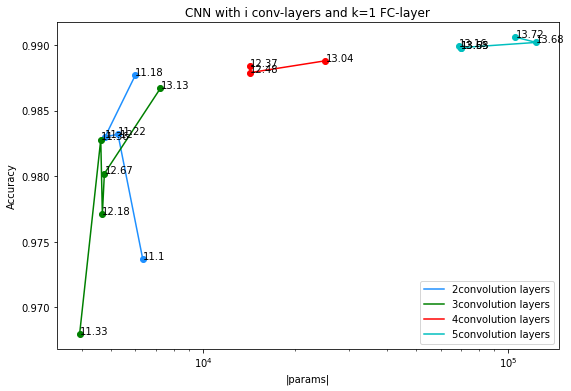

In [ ]:
d_df_fc = {}
for i in range (2, 6):
    df = pd.DataFrame(d_big_history[i])
    df.to_excel('/content/drive/MyDrive/Graduation_paper/hist_of_cnn_1fc_'+str(i)+'_training.xlsx')
    d_df_fc[i]=df
colors = ['dodgerblue','g','r','c','m','orange']

plt.figure(figsize=(9,6))
plt.title('CNN with i conv-layers and k=1 FC-layer')
for i in range(2,6):
    #plt.figure(figsize=(9,6))
    plot_acc_params_dependency(l_acc=list(d_df_fc[i].iloc[2]), l_time=list(d_df_fc[i].iloc[1]), l_n_parameters=list(d_df_fc[i].iloc[3]),
                               colour=colors[i-2], s_xscale='log', s_yscale='linear', n_epochs=10)
plt.legend([(str(i)+' convolution layers') for i in range(2,6)])

In [ ]:
lr = LR
#d_very_big_history={}
d_big_history2={}
dl_dims ={}
dl_dims[2] = [[5,5], [4,4], [3,3],[2,2]]
dl_dims[3] = [[5,4,3],[5,3,2],[4,3,2], [3,3,2],[2,2,2]]
dl_dims[4] = [[5,5,5,2],[5,3,2,2],[4,3,2,2],[3,3,3,2],[2,2,2,2]]
dl_dims[5] = [[5,5,5,5,2],[5,5,4,4,3], [5,4,3,3,2],[4,4,3,3,2], [3,3,3,3,2], [2,2,2,2,2]]
dl_dims[6] = [[5,5,5,5,5,2],[5,5,4,4,4,3], [5,4,4,3,3,2],[4,4,3,3,2,2], [3,3,3,3,3,2],[2,2,2,2,2,2]]
l_paddings={2:1, 3:1, 4:2, 5:2, 6:2}
for i in range(2,7):
  d_hist ={}
  for j in range(0, len(dl_dims[i])):
    cnn = CNN(n_conv_layers=i, n_FC_layers=2,
          l_n_conv_layers=[8,16, 32, 64, 128,256][:i], l_kernel_sizes=dl_dims[i][j], l_paddings=[l_paddings[i] for q in range (i)], l_strides=[1, 1,1,1,1,1][:i],
          l_fc_neurons=[128]).to(DEVICE)
    h, t, e, n_params = typical_workflow(cnn, train_DL,val_DL, n_epochs=10, init_lr=LR, lr_params={'step_size': 8, 'gamma': 0.1})
    d_hist[j] = [h, t, e, n_params]
  d_big_history2[i] = d_hist
d_very_big_history[2] = d_big_history2

In [ ]:
lr = LR
d_big_history3={}
dl_dims ={}
dl_dims[2] = [[5,5], [4,4], [3,3],[2,2]]
dl_dims[3] = [[5,4,3],[5,3,2],[4,3,2], [3,3,2],[2,2,2]]
dl_dims[4] = [[5,5,5,2],[5,3,2,2],[4,3,2,2],[2,2,2,2]]
dl_dims[5] = [[5,5,5,5,2],[5,5,4,4,3], [5,4,3,3,2],[4,4,3,3,2], [3,3,3,3,2],[2,2,2,2,2]]
dl_dims[6] = [[5,5,5,5,5,2],[5,5,4,4,4,3], [5,4,4,3,3,2],[4,4,3,3,2,2], [3,3,3,3,3,2],[2,2,2,2,2,2]]
dl_dims[7] = [[5,5,5,5,5,5,2],[5,5,4,4,4,3,3], [5,4,4,3,3,2,2],[4,4,4,3,3,2,2], [3,3,3,3,3,3,2],[2,2,2,2,2,2,2]]
l_paddings={2:1, 3:1, 4:2, 5:2, 6: 2, 7:2}
for i in range(2,8):
  d_hist ={}
  for j in range(0, len(dl_dims[i])):
    cnn = CNN(n_conv_layers=i, n_FC_layers=3,
          l_n_conv_layers=[8,16, 32, 64, 128,256, 320][:i], l_kernel_sizes=dl_dims[i][j], l_paddings=[l_paddings[i] for q in range (i)], l_strides=[1 for q in range(i)],
          l_fc_neurons=[256,128]).to(DEVICE)

    h, t, e, n_params = typical_workflow(cnn,train_DL,val_DL, n_epochs=10, init_lr=LR, lr_params={'step_size': 8, 'gamma': 0.1})
    d_hist[j] = [h, t, e, n_params]
  d_big_history3[i] = d_hist
d_very_big_history[2] = d_big_history3

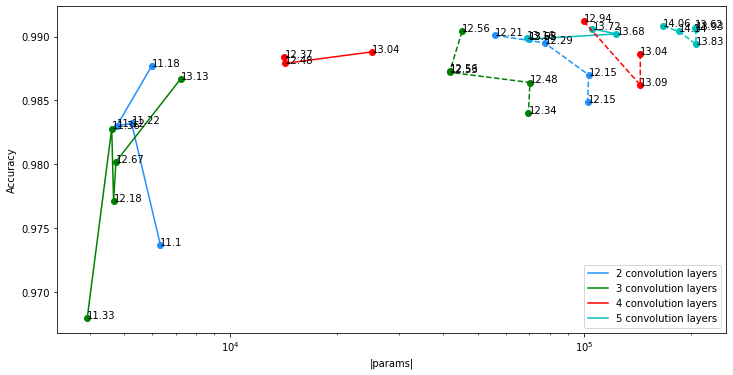

In [ ]:
plt.figure(figsize=(12,6))
for k in range(1,3):
    d_df_fc = {}
    for i in range (2, 2+len(d_very_big_history[k])):
        df = pd.DataFrame(d_very_big_history[k][i])
        df.to_excel('/content/drive/MyDrive/Graduation_paper/hist_of_cnn_fc'+str(k)+'_'+str(i)+'_training.xlsx')
        d_df_fc[i]=df
    colors = ['dodgerblue','g','r','c','m','orange']

    #plt.title('CNN with i conv-layers and k= FC-layer')
    for i in range(2,6):
        #plt.figure(figsize=(9,6))
        plot_acc_params_dependency(l_acc=list(d_df_fc[i].iloc[2]), l_time=list(d_df_fc[i].iloc[1]), l_n_parameters=list(d_df_fc[i].iloc[3]),
                                  colour=colors[i-2], s_xscale='log', s_yscale='linear', n_epochs=10, ls='-' if k==1 else '--' if k==2 else '.')
    plt.legend([(str(i)+' convolution layers') for i in range(2,6)])

## Аугментации

### Baseline model
Обучим одну из референсных моделей и посмотрим, насколько хорошо она классифицирует изобраения из валидационной выборки

In [ ]:
cnn = CNN(n_conv_layers=5, n_FC_layers=1,
          l_n_conv_layers=[8,16, 32, 64, 128], l_kernel_sizes=[5,5,5,5,2], l_paddings=[2 for q in range (5)], l_strides=[1 for q in range (5)],
          l_fc_neurons=[]).to(DEVICE)
h, t, e, n_params = typical_workflow(cnn, train_DL, val_DL,n_epochs=10, init_lr=LR, lr_params={'step_size': 8, 'gamma': 0.1})

In [ ]:
for X_val_batch, Y_val_batch in val_DL:
    break
#Y_val_batch.shape
plot_predicted_labeled_imgs(cnn, X_val_batch, Y_val_batch)

### Augmentations
Модифицируем (аугментируем) обучающую выборку. В ``` l_augmentations ``` перечислены текущие модификации


In [ ]:
from albumentations.imgaug.transforms import IAAAffine
import albumentations as A
import albumentations.augmentations.transforms, albumentations.core
import cv2

In [ ]:
from albumentations.imgaug.transforms import IAAAffine
import albumentations as A
import albumentations.augmentations.transforms, albumentations.core
l_augmentations = [
        A.ShiftScaleRotate(shift_limit=0.07, scale_limit=0.1, rotate_limit=30, p=1),
        A.Compose([A.RandomCrop(height=23, width=23, p=1),
                    A.augmentations.transforms.PadIfNeeded(min_height=IM_HEIGHT, min_width=IM_HEIGHT, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=[-1,-1,-1] )
                    ]),
        A.HorizontalFlip(p=1),
        A.augmentations.transforms.Blur(blur_limit=5, p=1),
        A.imgaug.transforms.IAAAdditiveGaussianNoise(loc=-0.3, scale=(0.01,0.5), p=1),
        A.IAAPiecewiseAffine(scale=(0.02,0.09), p=1),#same to ElasticTransform
        #A.IAAPerspective(scale=(0.05, 0.1), p=1)
    ]

In [ ]:
images[0].numpy().squeeze().shape

(28, 28)

Визуализируем, насколько предобученная на исходных данных референсная модель дает хорошие предсказания на аугментированных данных

In [ ]:
def visualise_augs_and_origs_with_confidence(model, X_batch, Y_batch, aug_pipeline, s_title=None):
    '''Similar to def plot_predicted_labeled_imgs(model, X_val_batch, Y_val_batch)'''
    n_cols = 8
    fig, ax = plt.subplots(nrows=2, ncols=n_cols, figsize=(n_cols*3, 6), sharey=True, sharex=True)
    plt.suptitle(s_title)
    for fig_x, fig_x2 in zip(ax[0], ax[1]):
        rand_idx = int(np.random.uniform(0,BATCH_SIZE))
        X, Y = X_batch[rand_idx], Y_batch[rand_idx]

        #X = X.data.cpu().numpy().squeeze()

        X_a = aug_pipeline(image=X.data.cpu().numpy().squeeze())['image']
        fig_x.imshow((1-X).data.cpu().numpy().squeeze(), cmap='gray')
        fig_x.set_title(str(Y.item()))
        fig_x.grid(False)

        fig_x.set_yticks([])
        fig_x.set_xticks([])

        X_a = torch.tensor(X_a)
        fig_x2 = fig_x2.twinx().twiny()
        fig_x2.imshow((1-X_a), cmap='gray')
        fig_x2.set_title(str(Y.item()))
        fig_x2.grid(False)

        fig_x2.set_yticks([])
        fig_x2.set_xticks([])

        prob_pred = predict_one_sample(model, X.unsqueeze(0))
        predicted_proba =np.max(prob_pred) *100
        y_pred = np.argmax(prob_pred)

        predicted_text = "{} : {:.2f}%".format(y_pred,predicted_proba)
        fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top', fontsize=10, color='red', fontweight='bold')

        X_a = X_a.unsqueeze(0).unsqueeze(0)
        prob_pred_aug = predict_one_sample(model,X_a)
        predicted_proba_aug =np.max(prob_pred_aug) *100
        y_a_pred = np.argmax(prob_pred_aug)

        predicted_text_aug = "{} : {:.2f}%".format(y_a_pred,predicted_proba_aug)
        fig_x2.text(1, 1, predicted_text_aug, horizontalalignment='left', verticalalignment='top', fontsize=10, color='red', fontweight='bold')

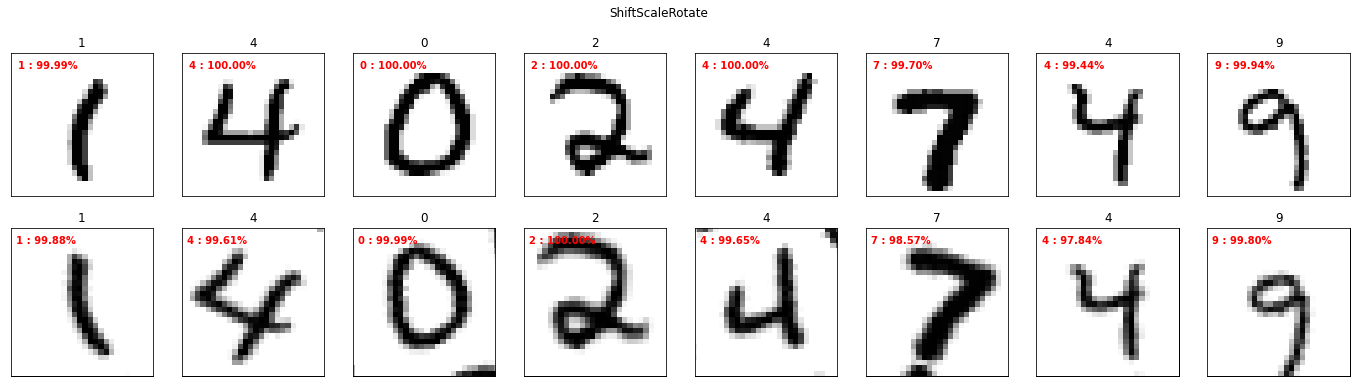

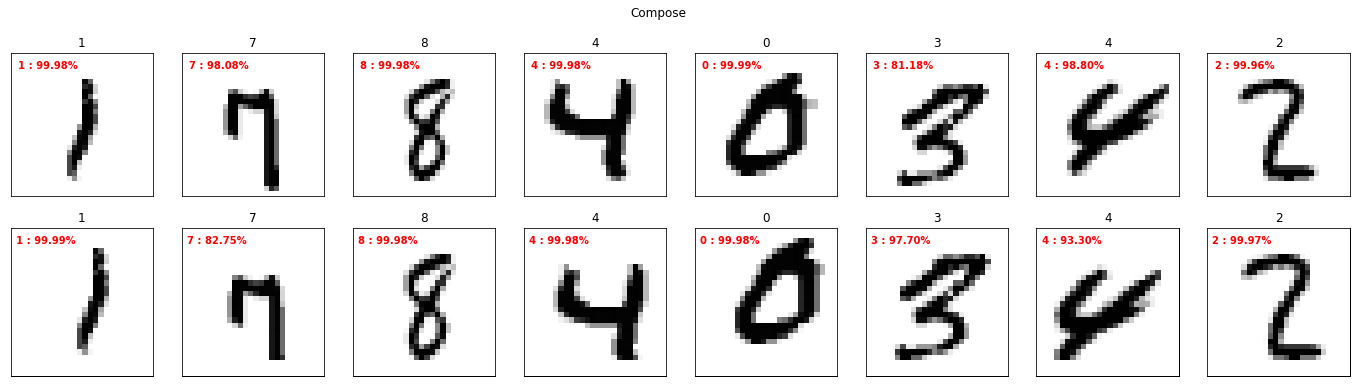

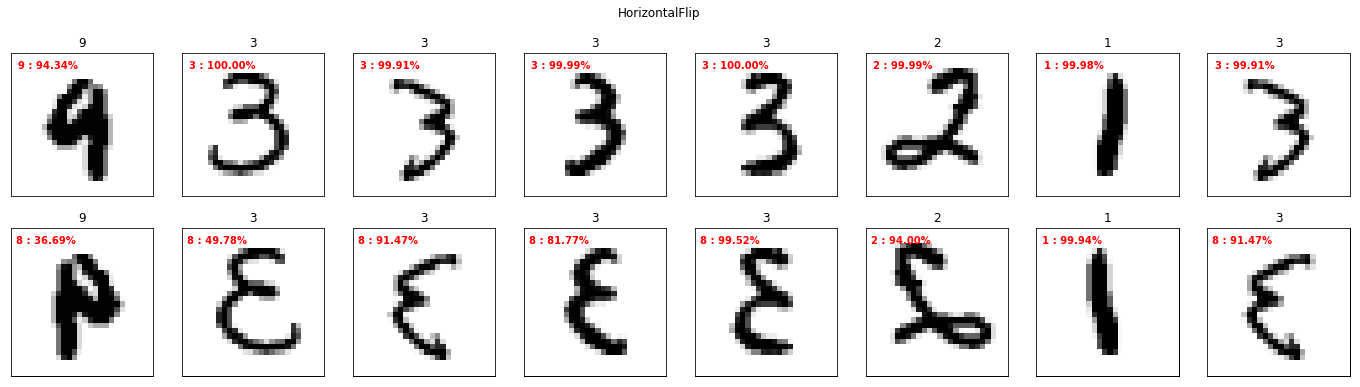

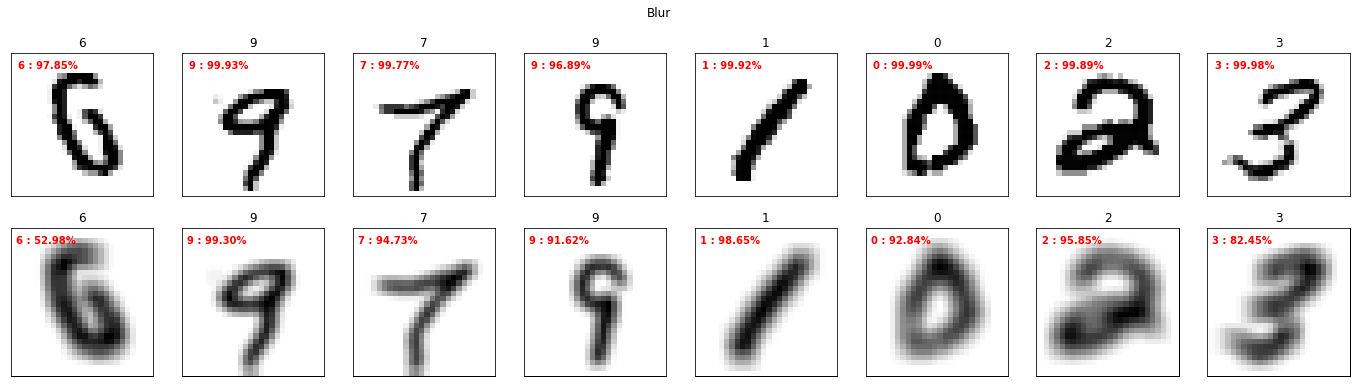

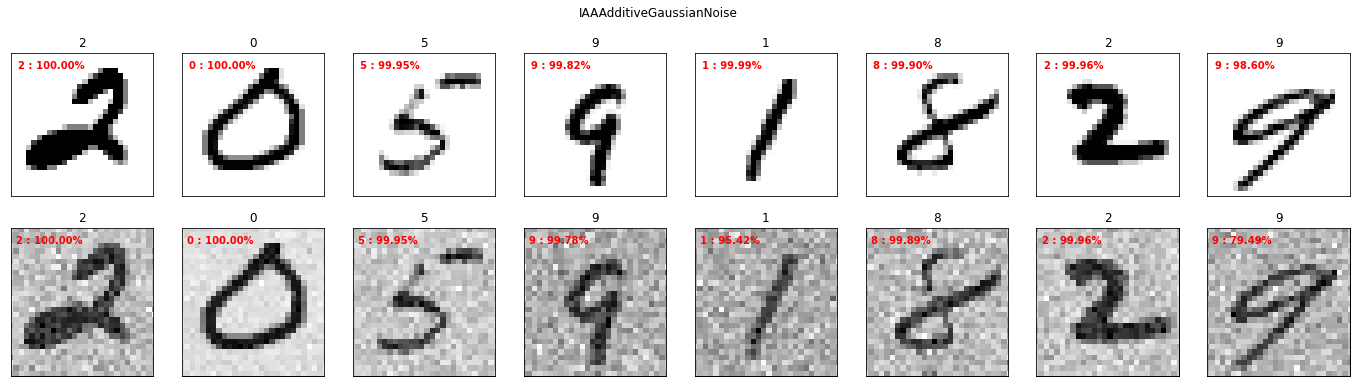

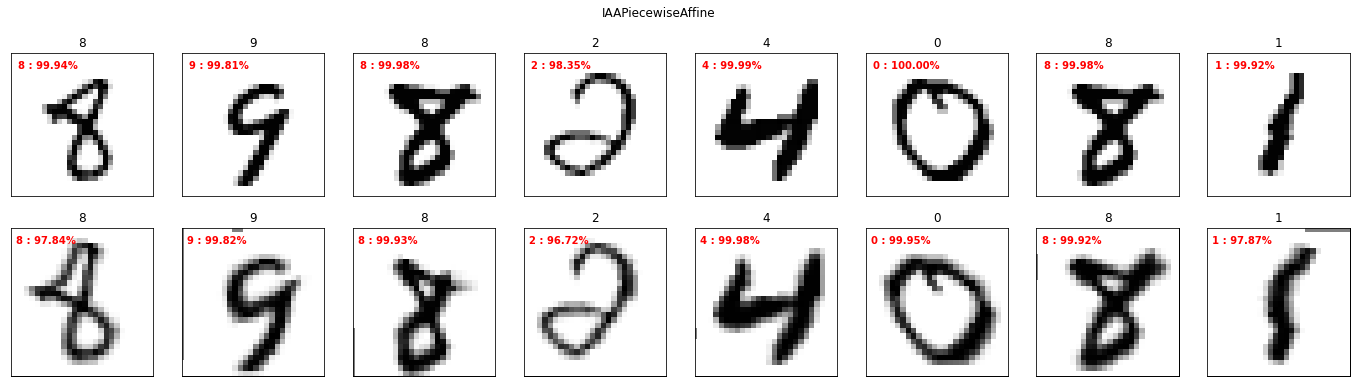

In [ ]:
for aug in l_augmentations:
    for X_val_batch, Y_val_batch in val_DL:
        break
    #val symbols are modified in func below:
    visualise_augs_and_origs_with_confidence(model=cnn, X_batch=X_val_batch, Y_batch=Y_val_batch, aug_pipeline=aug, s_title=str(type(aug).__name__) )

### Последовательно применим отобранные аугментацию к датасету
Затем применим их вместе.
Будем варьировать вероятности по убыванию от нескольких десятков процентов до нескольких.

In [ ]:
MNIST_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

a_trainset = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform = MNIST_transform)
#we do nat change Val dataset
a_valset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=MNIST_transform)
a_val_DL = torch.utils.data.DataLoader(a_valset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class ImageClassA():
    """Objects of this class do not change original dataset"""
    def __init__(self, dataset, transform=None, total_classes=None):
        self.transform = transform
        self.data = []

        for index, X in enumerate(dataset):
            data, target = X

            assert data.shape==(1,28,28)
            data = data.squeeze(dim=0)
            img = np.asarray(data)

            if self.transform is not None:
                augmentations = self.transform(image=img)
                img = augmentations["image"]

            target = torch.from_numpy(np.array(target))
            img = torch.from_numpy(img).unsqueeze(dim=0)
            self.data.append((img, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [ ]:
class ImageClassB():
    """Objects of this class do not change original dataset"""
    def __init__(self, dataset, transform=None, total_classes=None):
        self.transform = transform
        self.data = dataset# []

        #for index, X in enumerate(dataset):
        #    self.data.append(X)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data, target = self.data[index]

        assert data.shape==(1,28,28)
        data = data.squeeze(dim=0)

        img = np.asarray(data)

        if self.transform is not None:
            augmentations = self.transform(image=img)
            img = augmentations["image"]

        target = torch.from_numpy(np.array(target))
        img = torch.from_numpy(img).unsqueeze(dim=0)

        return img,target

In [ ]:
d_very_big_history = {}

#### Обучение

In [ ]:
for p in [0.15, 0.3, 0.5, 0.7, 0.9]:
    d_big_history = {}
    l_augmentations = [
          A.Compose([A.RandomCrop(height=23, width=23, p=p),
                    A.augmentations.transforms.PadIfNeeded(min_height=IM_HEIGHT, min_width=IM_HEIGHT, p=1.0, border_mode=cv2.BORDER_CONSTANT )
                    ]),
          A.HorizontalFlip(p=p),
          #A.IAAPiecewiseAffine(scale=(0.02,0.09), p=p),#same to ElasticTransform
          A.ShiftScaleRotate(shift_limit=0.07, scale_limit=0.1, rotate_limit=30, p=p),
          A.Compose([A.RandomCrop(height=23, width=23, p=p),
                    A.augmentations.transforms.PadIfNeeded(min_height=IM_HEIGHT, min_width=IM_HEIGHT, p=1.0, border_mode=cv2.BORDER_CONSTANT ),
                    A.HorizontalFlip(p=p)])
      ]
    lr = 2*LR
    for i in range(len(l_augmentations)):
        d_history = {}

        current_aug = l_augmentations[i]
        print(f'Current augmentation is {str(type(current_aug).__name__)} with p={p}')
        new_a_trainset = ImageClassB(a_trainset, transform=current_aug)
        a_train_DL = torch.utils.data.DataLoader(new_a_trainset, batch_size=BATCH_SIZE, shuffle=True)

        for k in range(1,3):#n of fc layers in CNN
            l_fc_neurons = [128 for _ in range(k-1)]
            cnn = CNN(n_conv_layers=5, n_FC_layers=k,
                        l_n_conv_layers=[8,16, 32, 64, 128], l_kernel_sizes=[5,5,5,5,2], l_paddings=[2 for q in range (5)], l_strides=[1 for q in range (5)],
                        l_fc_neurons=l_fc_neurons).to(DEVICE)
            h, t, e, n_params = typical_workflow(cnn, train_DL = a_train_DL, val_DL =a_val_DL,
                                                        n_epochs=round(N_MAX_EPOCHS*(1+p)/2), init_lr=lr, lr_params={'step_size': 8, 'gamma': 0.1})

            d_history[k] = [h,t,e,n_params]
        d_big_history[str(type(l_augmentations[i]).__name__)+'_'+str(i)] = d_history
    d_very_big_history[p] = d_big_history

In [ ]:
d_very_big_history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


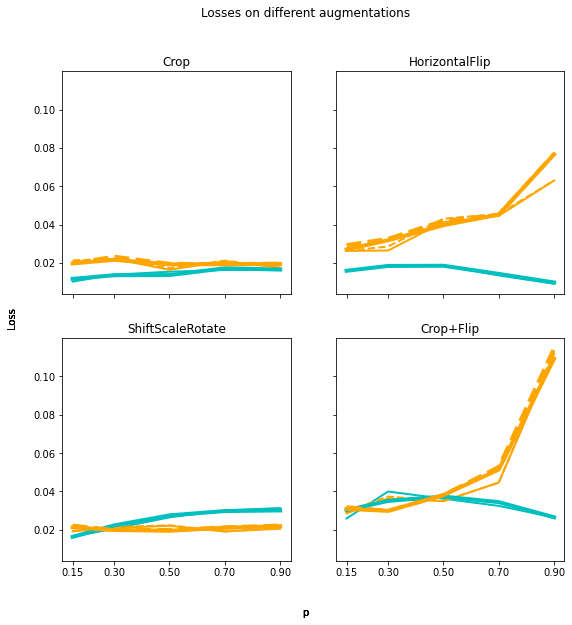

In [ ]:
s_augs = ['Crop', 'HorizontalFlip','ShiftScaleRotate', 'Crop+Flip']
l_p = [0.15, 0.3, 0.5, 0.7, 0.9]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), sharey=True, sharex=True)
plt.suptitle('Losses on different augmentations')
for idx, fig_x in enumerate(ax.flatten()):
    fig_x.set_title(s_augs[idx])

    for k in range(1,3):#foreach cnn
        l_min_train_losses, l_min_val_losses, l_last_val_losses = [],[],[]
        hh = np.array([d_very_big_history[p][s_augs[idx]][k] for p in l_p])

        for i_p, p in enumerate(l_p):
            l_min_train_losses.append(min(np.array(hh[i_p,0])[:,0]))
            l_min_val_losses.append(min(np.array(hh[i_p,0])[:,1]))
            l_last_val_losses.append(np.array(hh[i_p,0])[:,1][-1])

        fig_x.plot(l_p, l_min_train_losses, c='c', linewidth=2*k)
        fig_x.plot(l_p, l_min_val_losses, c='orange', linewidth=2*k)
        fig_x.plot(l_p, l_last_val_losses, c='orange',ls='--', linewidth=2*k)
        fig_x.set_xticks(l_p)
    fig.text(0.5, 0.04, 'p', ha='center')
    fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical')
    #ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)


Посмотрим на точность предсказаний: лучшие результаты (причем с улучшением относительно предыдущего раздела) показывают модификации Crop и ShiftScaleRotate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


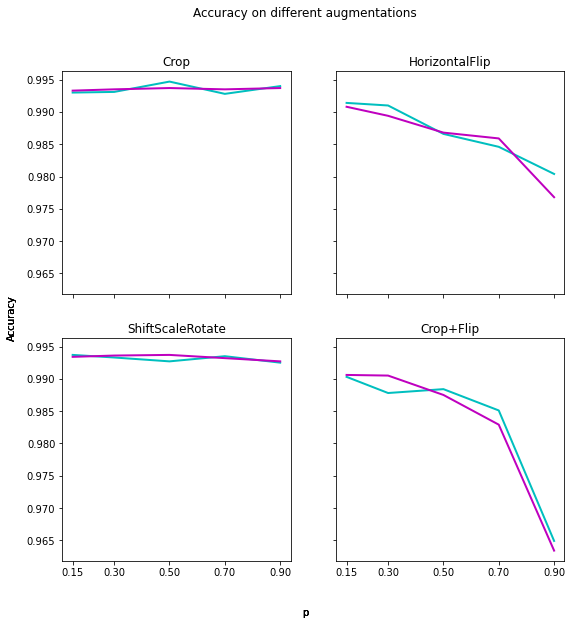

In [ ]:
s_augs = ['Crop', 'HorizontalFlip','ShiftScaleRotate', 'Crop+Flip']
l_p = [0.15, 0.3, 0.5, 0.7, 0.9]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), sharey=True, sharex=True)
plt.suptitle('Accuracy on different augmentations')
for idx, fig_x in enumerate(ax.flatten()):
    fig_x.set_title(s_augs[idx])

    for k in range(1,3):#foreach cnn
        l_acc=[]
        hh = np.array([d_very_big_history[p][s_augs[idx]][k] for p in l_p])

        for i_p, p in enumerate(l_p):
            l_acc.append(np.array(hh[i_p,2]))

        fig_x.plot(l_p, l_acc, c='c' if k==1 else 'm' if k==2 else 'b', linewidth=2)
        fig_x.set_xticks(l_p)
    fig.text(0.5, 0.04, 'p', ha='center')
    fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical')
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

## Модификации шрифтов

На GDrive необходимо поместить zip-архив `fonts4.zip` с некоторыми шрифтами

In [ ]:
from albumentations.imgaug.transforms import IAAAffine
import albumentations as A
import albumentations.augmentations.transforms, albumentations.core
import cv2
from PIL import ImageFont, Image, ImageDraw
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive/')

!unzip -q /content/drive/MyDrive/fonts4.zip -d fonts_dir4
FONTS_DIR = Path('fonts_dir4')
fonts_files = sorted(list(FONTS_DIR.rglob('*.ttf')))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls fonts_dir4

fonts4


In [ ]:
len(fonts_files)

31

In [ ]:

class FontsDataset():
    """ Creates a container of digits in itself   """
    def __init__(self, files, transform=None, multiply_factor=1, dataset=None, p=0):
        super().__init__()
        #List of files
        self.files = sorted(files)
        self.transform = transform

        self.len_ = 10*len(self.files)

        self.data = []
        if dataset is not None:#MNIST already transformed
            for q in range(round((1-p)*60000)):
                data, target = dataset[q]

                if data.shape==(1,28,28):
                    data = data.squeeze()
                assert data.shape==(28,28)

                img = np.asarray(data)

                self.data.append([img,target])

        for f in files:
            for i_digit in range(0,10):
                curr_font = ImageFont.truetype(font=str(f), size=20)
                image = Image.new(mode='L', size=(28,28), color='#000000')
                # Create an ImageDraw object onto which the font text will be placed
                draw = ImageDraw.Draw(im=image)
                # Draw the text onto our image
                target = i_digit
                draw.text(xy=(5,-5), text=str(target), font=curr_font, fill='white')#, anchor='mm')
                image = MNIST_transform(image)
                for tm in range(multiply_factor):
                    img = np.array(image)
                    if img.shape==(1,28,28):
                        img = img.squeeze()
                    assert img.shape==(28,28)

                    if  self.transform is not None:
                        if  type(self.transform)==list:
                            for aug in self.transform:
                                img = np.asarray(img)

                                self.data.append([aug(image=img)['image'],target])
                        else:
                            augmentations = self.transform(image=img)
                            img = augmentations["image"]
                            self.data.append([img,target])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data, target = self.data[index]



        target = torch.from_numpy(np.array(target))
        img = torch.from_numpy   (data).unsqueeze(dim=0)

        return img,target

In [ ]:
f_trainset = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform = MNIST_transform)
#we do nat change Val dataset
f_valset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=MNIST_transform)
f_val_DL = torch.utils.data.DataLoader(f_valset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
l_augmentations = [
          A.IAAPiecewiseAffine(scale=(0.02,0.04), p=1),#same to ElasticTransform
          A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.02, rotate_limit=7, p=1)
      ]
new_f_trainset = FontsDataset(fonts_files, transform=l_augmentations, multiply_factor=5)#, dataset = f_trainset, p=0.2)
f_train_DL = torch.utils.data.DataLoader(new_f_trainset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
len(new_f_trainset)

3100

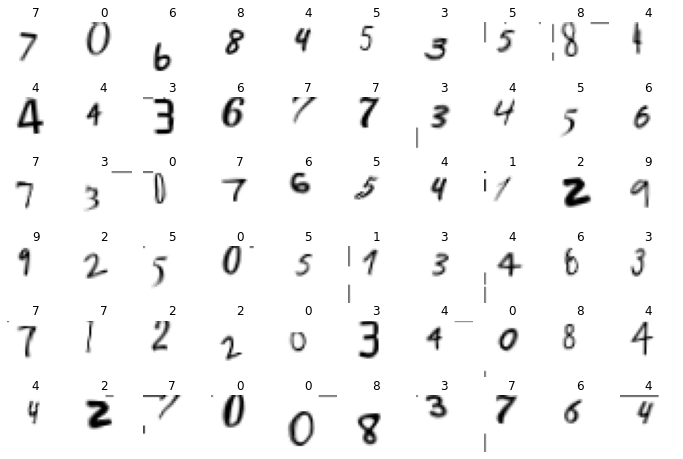

In [ ]:
for Xb, Yb in f_train_DL:
    break

figure = plt.figure(figsize=(12, 8))
num_of_images = 60
for i in range(1, num_of_images + 1):
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(Xb[i][0], cmap='gray_r')
    plt.title(str(Yb[i].item()))

In [ ]:
visualise_augs_and_origs_with_confidence(model=cnn, X_batch=Xb, Y_batch=Yb, aug_pipeline=A.RandomCrop(height=28, width=28, p=0), s_title='Affine, Shift and ScaleRotate' )

In [ ]:
cnn = CNN(n_conv_layers=5, n_FC_layers=1,
          l_n_conv_layers=[8,16, 32, 64, 128], l_kernel_sizes=[5,5,5,5,2], l_paddings=[2 for q in range (5)], l_strides=[1 for q in range (5)],
          l_fc_neurons=[]).to(DEVICE)
h, t, e, n_params = typical_workflow(cnn, f_train_DL, f_val_DL, n_epochs=10, init_lr=LR, lr_params={'step_size': 8, 'gamma': 0.1})

In [ ]:
MNIST_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

F_TRAINSET = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform = MNIST_transform)
#we do nat change Val dataset
valset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=MNIST_transform)
val_DL = torch.utils.data.DataLoader(f_valset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
d_very_big_history={}

Обучение моделей

In [ ]:
for p1 in [0.15, 0.3]:#, 0.5, 0.7, 0.9]:
    d_big_history = {}
    lr = LR
    for p2 in [0.7, 0.82, 0.9, 1]:
        d_history = {}
        l_augmentations = [
          A.IAAPiecewiseAffine(scale=(0.02,0.04), p=p2),#same to ElasticTransform
          A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.02, rotate_limit=7, p=p2)
      ]
        mult_factor = round((60000*(p1))/len(l_augmentations)/len(fonts_files)/10)
        print('Multiplication factor is ' + str(mult_factor))

        new_f_trainset = FontsDataset(fonts_files, transform=l_augmentations, multiply_factor=mult_factor, dataset = F_TRAINSET, p=p1)
        f_train_DL = torch.utils.data.DataLoader(new_f_trainset, batch_size=BATCH_SIZE, shuffle=True)

        for k in range(1,3):#n of fc layers in CNN
            l_fc_neurons = [128 for _ in range(k-1)]
            cnn = CNN(n_conv_layers=5, n_FC_layers=k,
                        l_n_conv_layers=[8,16, 32, 64, 128], l_kernel_sizes=[5,5,5,5,2], l_paddings=[2 for q in range (5)], l_strides=[1 for q in range (5)],
                        l_fc_neurons=l_fc_neurons).to(DEVICE)
            h, t, e, n_params = typical_workflow(cnn, train_DL = f_train_DL, val_DL =val_DL,
                                                        n_epochs=round(N_MAX_EPOCHS*(1+p1)/2), init_lr=lr, lr_params={'step_size': 8, 'gamma': 0.1})

            d_history[k] = [h,t,e,n_params]
        d_big_history[p2] = d_history
    d_very_big_history[p1] = d_big_history

Покажем, что модели переобучились при таких модификациях обучающих данных

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


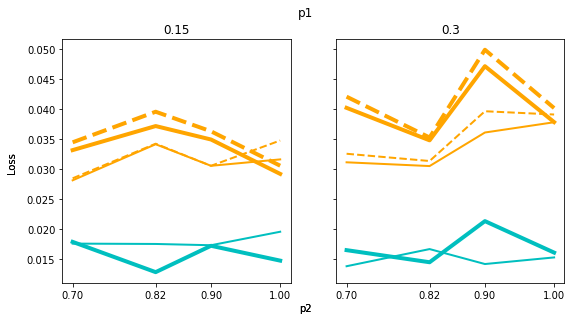

In [ ]:
l_p2 = [0.7, 0.82, 0.9, 1]
l_p = [0.15, 0.3]#, 0.5, 0.7, 0.9]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5), sharey=True, sharex=True)
plt.suptitle('p1')
for idx, fig_x in enumerate(ax.flatten()):
    fig_x.set_title(l_p[idx])

    for k in range(1,3):#foreach cnn
        l_min_train_losses, l_min_val_losses, l_last_val_losses = [],[],[]
        hh = np.array([d_very_big_history[l_p[idx]][p2][k] for p2 in l_p2])

        for i_p, p in enumerate(l_p2):
            l_min_train_losses.append(min(np.array(hh[i_p,0])[:,0]))
            l_min_val_losses.append(min(np.array(hh[i_p,0])[:,1]))
            l_last_val_losses.append(np.array(hh[i_p,0])[:,1][-1])

        fig_x.plot(l_p2, l_min_train_losses, c='c', linewidth=2*k)
        fig_x.plot(l_p2, l_min_val_losses, c='orange', linewidth=2*k)
        fig_x.plot(l_p2, l_last_val_losses, c='orange',ls='--', linewidth=2*k)
        fig_x.set_xticks(l_p2)
    fig.text(0.5, 0.04, 'p2', ha='center')
    fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical')
    #ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)


In [ ]:
d_high = {}
for p1 in [0.15]: #, 0.3]:#, 0.5, 0.7, 0.9]:
    d_big_history = {}
    lr = LR
    for p2 in [0.7, 0.82, 0.9, 1]:
        d_history = {}
        l_augmentations = [
          A.IAAPiecewiseAffine(scale=(0.02,0.04), p=p2),#same to ElasticTransform
          A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.02, rotate_limit=7, p=p2)
      ]
        mult_factor = round((60000*(p1))/len(l_augmentations)/len(fonts_files)/10)
        print('Multiplication factor is ' + str(mult_factor))

        new_f_trainset = FontsDataset(fonts_files, transform=l_augmentations, multiply_factor=mult_factor, dataset = F_TRAINSET, p=p1)
        f_train_DL = torch.utils.data.DataLoader(new_f_trainset, batch_size=BATCH_SIZE, shuffle=True)

        for k in range(2,4):#n of fc layers in CNN
            l_fc_neurons = [128 for _ in range(k-1)]
            cnn = CNN(n_conv_layers=6, n_FC_layers=k,
                        l_n_conv_layers=[8,16, 32, 64, 128, 256], l_kernel_sizes=[5,5,5,5,5,2], l_paddings=[2 for q in range (6)], l_strides=[1 for q in range (6)],
                        l_fc_neurons=l_fc_neurons).to(DEVICE)
            h, t, e, n_params = typical_workflow(cnn, train_DL = f_train_DL, val_DL =val_DL,
                                                        n_epochs=round(N_MAX_EPOCHS*(1+p1)/2), init_lr=lr, lr_params={'step_size': 8, 'gamma': 0.1})

            d_history[k] = [h,t,e,n_params]
        d_big_history[p2] = d_history
    d_high[p1] = d_big_history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'accuracy')

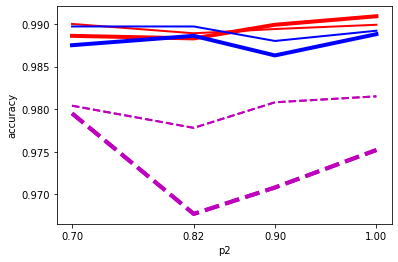

In [ ]:
l_p2 = [0.7, 0.82, 0.9, 1]
l_p = [0.15, 0.3]#, 0.5, 0.7, 0.9]
#plt.suptitle('p1')
for idx in range(len(l_p)):
    fig_x.set_title(l_p[idx])

    for k in range(1,3):#foreach cnn
        l_acc = []
        l_acc_high =[]
        hh = np.array([d_very_big_history[l_p[idx]][p2][k] for p2 in l_p2])
        h2= np.array([d_high[p2][1+k] for p2 in l_p2])
        for i_p, p in enumerate(l_p2):
            l_acc.append(hh[i_p,2])
            l_acc_high.append(h2[i_p,2])
        plt.plot(l_p2, l_acc, c='r' if l_p[idx]==0.15 else 'b', linewidth=2*k)
        plt.plot(l_p2, l_acc_high, c='m', ls='--' , linewidth=round(k*2))
plt.xticks(l_p2)
plt.xlabel('p2')
plt.ylabel('accuracy')

Красные и Синии ломаные соответствуют моделям с 5 сверточными слоями, фиолетовые - с 6-ю. Синяя ломаная соответствует результатам для обучающих данных с долей импутированных символов 0.3, а красная  - 0.15, фиолетовая - также для 0.15.  На оси абсцисс - вероятность применения данной модификации. График демонстрирует, что модели с 5-ю сверточными слоями дают результаты при такой технике модификации обучающих данных лучше - потому, что переобуаются  меньше, тк параметров у них меньше.